In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import collections

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_rows = 100
from statsmodels.stats import multitest
from scipy import stats

import pysam
import time
import glob
import re
import os

# Prepare plotting of 3' UTR read buildup

In [100]:
def plot_read_buildup_3UTR(gene,ann,bam_paths,axs,onts=None,ws=10,count_threshold=0,scale_bar_size=5000):

    gene_gtf = ann[ann['gene_name'].eq(gene)]
    chrom = gene_gtf['chrom'].unique()[0]
    strand = 'plus' if gene_gtf['strand'].unique()[0] == '+' else 'minus'

    xmin,ymin,xmax,ymax = None,0,None,None

    for i,(transcript_id,transcript_df) in enumerate(gene_gtf.groupby('transcript_id')):
        y = 2*(i+1)
        #Draw a line for the intro from the total start to total end
        min_x_transcript = transcript_df['start'].min()
        max_x_transcript = transcript_df['stop'].max()

        intron_line = Rectangle(
            (min_x_transcript, y - 0.1),
            max_x_transcript - min_x_transcript, 0.2,
            linewidth=1,edgecolor='k',facecolor='k',
        )
        axs[0].add_patch(intron_line)

        prev_5UTR = False
        prev_3UTR = False
        for _,feature in transcript_df.iterrows():
            #NOTE!! JUST PRINTING 3' UTR
            if feature['kind'] != 'three_prime_UTR':
                continue
            
            height = 1
            #Sometimes there are multiple 5' and 3' UTRs for a single transcript??? just using the first
            if feature['kind'] == 'five_prime_UTR':
                if prev_5UTR:
                    continue
                prev_5UTR = True
                height = 0.5

            if feature['kind'] == 'three_prime_UTR':
                if prev_3UTR:
                    continue
                prev_3UTR = True
                height = 0.5

            ymax = y+1

            x = feature['start']
            xmin = min(xmin,x) if xmin else x

            width = feature['stop']-feature['start']
            xmax = max(xmax,feature['stop']) if xmax else feature['stop']

            rect = Rectangle(
                (x, y - height/2),
                width, height,
                linewidth=0.5,edgecolor='k',facecolor='white',
            )
            axs[0].add_patch(rect)

    gene_width = xmax-xmin
    view_width = 1.1*gene_width
    offset = (view_width-gene_width)/2

    scale = Rectangle(
        (xmin-offset, -0.5),
        scale_bar_size, 1,
        linewidth=0.5,edgecolor='k',facecolor='blue',
    )
    axs[0].add_patch(scale)

    axs[0].set_xlim(xmin-offset,xmax+offset)
    axs[0].set_ylim(-1,ymax)
    axs[0].axis('off')


    #Now plotting the CDFs of each cell-type (added up across all 10X mice)
    count_df = pd.DataFrame()

    start = time.time()
    for ont in onts:

        tot_counts = 0
        pos_counts = {p:0 for p in range(xmin//ws*ws,xmax//ws*ws+ws,ws)}

        for mouse,ont_paths in bam_paths.items():
            if ont not in ont_paths:
                continue
        
            with pysam.AlignmentFile(ont_paths[ont]) as bam:
                for r in bam.fetch(chrom,xmin,xmax):
                    if r.pos < xmin or r.pos > xmax:
                        continue
                    pos_counts[r.pos//ws*ws] += 1
                    tot_counts += 1

        ont_df = pd.DataFrame({'pos':pos_counts.keys(),'count':pos_counts.values()})
        ont_df['ont'] = ont

        count_df = pd.concat((count_df,ont_df))

        
    #Sometimes a 3' UTR won't have any ontologies with enough reads
    #in which case don't make a plot
    if len(count_df) == 0:
        plt.close()
        return None
        
        
    #print('Took {} seconds to get pysam reads'.format(time.time()-start))
    start = time.time()
    
    count_df['cumulative'] = count_df.groupby('ont')['count'].transform('cumsum')
    count_df['cumulative'] = count_df.groupby('ont')['cumulative'].transform(lambda v: v/v.max())
    
    ont_to_median_pos = count_df.groupby('ont')['cumulative'].apply(lambda c: sum(c < 0.5))
    count_df['median_pos'] = count_df['ont'].map(ont_to_median_pos)
    count_df = count_df.sort_values('median_pos')

    #print('Took {} seconds to cumsum reads'.format(time.time()-start))
    start = time.time()
    
    sns.lineplot(
        x = 'pos',
        y = 'count',
        hue = 'ont',
        hue_order = onts,
        palette = 'viridis',
        data = count_df,
        ax = axs[1],
    )
    axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #print('Took {} seconds to lineplot counts'.format(time.time()-start))
    start = time.time()
    
    sns.lineplot(
        x = 'pos',
        y = 'cumulative',
        hue = 'ont',
        hue_order = onts,
        palette = 'viridis',
        data = count_df,
        ax = axs[2],
        legend = False,
    )
    #print('Took {} seconds to lineplot cumsum'.format(time.time()-start))
    #plt.xticks([])
    #plt.suptitle("{} {} {} strand 3' UTR".format(gene,chrom,strand))
    return count_df

#Collect the different mouse/ont BAM paths
bam_stem = '/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_mapping/merged_by_mouse_celltype'

mice = set()
onts = set()
mouse_onts = collections.defaultdict(dict)

rzs_to_merf_ont_map = {
    'Astro':'Astro',
    'Endo':'Endo',
    'L23_IT':'L2/3 IT',
    'L56_NP':'L5/6 NP',
    'L5_ET':'L5 ET',
    'L5_IT':'L5 IT',
    'L6_CT':'L6 CT',
    'L6_IT':'L6 IT',
    'L6_IT_Car3':'L6 IT Car3',
    'L6b':'L6b',
    'Lamp5':'Lamp5',
    'Macrophage':'Macrophage',
    'OPC':'OPC',
    'Oligo':'Oligo',
    'Pvalb':'Pvalb',
    'SMC':'SMC',
    'Sncg':'Sncg',
    'Sst':'Sst',
    'VLMC':'VLMC',
    'Vip':'Vip',
}

for p in glob.glob(os.path.join(bam_stem,'*.bam')):
    name = os.path.basename(p)
    mouse = name.split('_')[0]
    ont = re.findall('Mouse._(.*).bam',name)[0]
    ont = rzs_to_merf_ont_map[ont]
    mice.add(mouse)
    onts.add(ont)
    mouse_onts[mouse][ont] = p
    
merf_gtf = pd.read_csv('/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/plotting/merf_gtf.csv')


# 3' UTR level ReadZs correlations with MOp datasets

I'd like to run the correlation on all datasets, but the ReadZs has so far only been run on MOp data with matching cell-types

In [3]:
#data
slrrp_samples = {
    'MOp_periph':'../outputs/gene_cell/MOp_peripheral_ReadZs_gene_ontology.csv',
    'MOp_radial':'../outputs/gene_cell/MOp_radial_ReadZs_gene_ontology.csv',
    'MOp_punctate':'../outputs/gene_cell/MOp_punctate_10X_ontology.csv',
    #'Viz_periph':'../outputs/gene_cell/Vizgen_Brainmap_peripheral.csv',
    #'Viz_radial':'../outputs/gene_cell/Vizgen_Brainmap_radial.csv',
    #'Viz_punctate':'../outputs/gene_cell/Viz_punctate.csv',
    #'SeqFish_periph':'../outputs/gene_cell/SeqFish_peripheral.csv',
    #'SeqFish_radial':'../outputs/gene_cell/SeqFish_radial.csv',
    #'SeqFish_punctate':'../outputs/gene_cell/SeqFish_punctate.csv',
}

#read in the 10X ReadZs gene-level dataset without UNNANN filter
rz_10x_UTR_no_unann = pd.read_csv('../outputs/readzs/UTR_level/MOp_10Xv3_no_unann_filt.csv')
rz_10x_UTR_no_unann = rz_10x_UTR_no_unann.rename(columns={'mouse':'readzs_mouse'})
rz_10x_UTR_no_unann.head()

,window,ontology_mouse,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,ontology,readzs_mouse,chr,strand,gene,rz_bh_corrected
0,chr3_Pdgfc_plus,L6 IT Car3___457909,12,1.0,-1.227383,0.0,0.06,False,2.523906,L6 IT Car3,457909,chr3,+,Pdgfc,0.136854
1,chr3_Pdgfc_plus,Vip___457909,11,1.0,-0.425359,0.0,0.06,False,2.523906,Vip,457909,chr3,+,Pdgfc,0.136854
2,chr3_Pdgfc_plus,L5/6 NP___457909,59,1.0,-0.316588,0.0,0.06,False,2.523906,L5/6 NP,457909,chr3,+,Pdgfc,0.136854
3,chr3_Pdgfc_plus,Pvalb___457909,12,1.0,-0.084358,0.0,0.06,False,2.523906,Pvalb,457909,chr3,+,Pdgfc,0.136854
4,chr3_Pdgfc_plus,L6 CT___457909,617,1.0,-0.063885,0.0,0.06,False,2.523906,L6 CT,457909,chr3,+,Pdgfc,0.136854


In [4]:
#The reason why L2/3 IT and L5 IT only have a single MERFISH mouse
#is because Flt1 is only found to be present in these ontologies in mouse 1
#
#there are filters before this stage that might get rid of this Flt1 data...
#
#I guess I want to change how I'm filtering here to ensure that each gene/ont is present in both mice
#
slrrp_df = pd.read_csv('../outputs/gene_cell/MOp_peripheral_ReadZs_gene_ontology.csv')

print('Flt1')
slrrp_df[
    slrrp_df['gene'].eq('Flt1')
].groupby('ontology').agg(
    num_mice = ('mouse','nunique'),
    num_samples = ('sample_id','nunique'),
).reset_index()


Flt1


,ontology,num_mice,num_samples
0,Astro,2,9
1,Endo,2,12
2,L2/3 IT,1,1
3,L5 IT,1,2
4,OPC,2,5
5,Oligo,2,12
6,SMC,2,12
7,VLMC,2,12


In [108]:
corr_data = collections.defaultdict(list)

for sample,path in slrrp_samples.items():

    #Pull directly from gene_cell table because I want to collapse per mouse (2 mice total)
    slrrp_df = pd.read_csv(path)
    
    gb_cols = ['mouse','gene','ontology']

    #filter SRRS results to
    #1. Drop gene/cells which have fewer than 5 gene spots of interest
    #2. Drop gene/cell-type/mouse with fewer than 20 cells
    #3. gene/ontology has to be present in both mice
    slrrp_df = slrrp_df[slrrp_df['num_gene_spots'].ge(5)]
    slrrp_df = slrrp_df.groupby(gb_cols).filter(lambda g: len(g) >= 20)
    slrrp_df = slrrp_df.groupby(['gene','ontology']).filter(lambda g: g['mouse'].nunique() > 1)

    #aggregate by mouse (over all slices)
    #Calculate z from Lyapunov CLT for each gene in each sample
    slrrp_agg_df = slrrp_df.groupby(gb_cols).agg(
        num_cells = ('cell_id','nunique'),
        num_slices = ('sample','nunique'),
        med_gene_spots = ('num_gene_spots','median'),
        med_spots = ('num_spots','median'),
        med_score = ('score','median'),
        score_sum = ('score','sum'),
        var_sum = ('variance','sum'),
    ).reset_index()

    slrrp_agg_df['z'] = slrrp_agg_df['score_sum']/np.sqrt(slrrp_agg_df['var_sum'])

    #Calculate two-sided p and BH correct ps
    p_onesided = stats.norm.cdf(slrrp_agg_df['z'])
    slrrp_agg_df['p'] = 2*np.minimum(p_onesided, 1-p_onesided)

    alpha = 0.05

    _,adj_p,_,_ = multitest.multipletests(
        slrrp_agg_df['p'],
        alpha = alpha,
        method = 'fdr_bh',
    )
    slrrp_agg_df['bh_p'] = adj_p
    slrrp_agg_df = slrrp_agg_df.rename(columns={'mouse':'merfish_mouse'})

    #merge the SRRS and ReadZs
    m_UTR = slrrp_agg_df.merge(rz_10x_UTR_no_unann, on=['gene','ontology'])
    m_UTR.head()

    #don't correlate ReadZs/SRRS genes with too few ontologies
    gene_sample_ontology_df = (
        m_UTR.groupby('gene').filter(
            lambda g: g['ontology'].nunique() >= 2)
    )

    for gene,g in gene_sample_ontology_df.groupby('gene'):
        corr_data['sample'].append(sample)
        corr_data['gene'].append(gene)
        corr_data['num_merfish_mice'].append(g['merfish_mouse'].nunique())
        corr_data['num_readzs_mice'].append(g['readzs_mouse'].nunique())
        corr_data['num_celltypes'].append(g['ontology'].nunique())
        corr_data['med_SRRS_cells_per_celltype'].append(g['num_cells'].median())
        corr_data['slrrp_span'].append(
            g.groupby('ontology')['med_score'].median().max()-g.groupby('ontology')['med_score'].median().min()
        )
        corr_data['readzs_span'].append(
            g.groupby('ontology')['median_z_scaled'].median().max()-g.groupby('ontology')['median_z_scaled'].median().min()
        )
        
        r,p = stats.pearsonr(g['med_score'],g['median_z_scaled'])
        corr_data['pearson_r'].append(r)
        corr_data['pearson_p'].append(p)
        
        r,p = stats.spearmanr(g['med_score'],g['median_z_scaled'])
        corr_data['spearman_r'].append(r)
        corr_data['spearman_p'].append(p)
        
#Convert to df
corr_df = pd.DataFrame(corr_data).dropna()

#BH multiple hypothesis correction for correlation p-values
_,adj_p,_,_ = multitest.multipletests(
    corr_df['pearson_p'],
    alpha = 0.05,
    method = 'fdr_bh',
)
corr_df['bh_pearson_p'] = adj_p

_,adj_p,_,_ = multitest.multipletests(
    corr_df['spearman_p'],
    alpha = 0.05,
    method = 'fdr_bh',
)
corr_df['bh_spearman_p'] = adj_p


corr_df

,sample,gene,num_merfish_mice,num_readzs_mice,num_celltypes,med_SRRS_cells_per_celltype,slrrp_span,readzs_span,pearson_r,pearson_p,spearman_r,spearman_p,bh_pearson_p,bh_spearman_p
0,MOp_periph,Adamts2,2,4,3,139.5,0.055926,0.029796,-0.080539,7.216222e-01,-0.018418,9.351624e-01,0.836048,1.000000e+00
1,MOp_periph,Adamts4,2,4,3,255.0,0.176421,0.111266,0.258130,2.718473e-01,0.404938,7.654352e-02,0.417447,1.554898e-01
2,MOp_periph,Adra1b,2,4,10,1843.0,0.107815,0.122184,0.004558,9.652209e-01,0.021046,8.404287e-01,0.979449,9.400351e-01
3,MOp_periph,Ano4,2,4,9,1031.0,0.164221,0.227280,-0.374461,8.999670e-05,-0.443542,2.409560e-06,0.000381,1.492146e-05
4,MOp_periph,Aqp4,2,2,2,2056.5,0.291814,0.073851,-0.076875,8.564272e-01,0.000000,1.000000e+00,0.930363,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,MOp_punctate,Unc5b,2,4,2,3695.5,0.129494,0.152241,0.219352,3.527891e-01,-0.156652,5.095419e-01,0.505406,6.729817e-01
449,MOp_punctate,Unc5d,2,4,6,1137.0,0.150255,0.228411,0.536778,8.220583e-07,0.571248,1.066086e-07,0.000005,8.780674e-07
450,MOp_punctate,Ust,2,4,10,661.0,0.174137,0.370724,-0.144107,1.705344e-01,-0.274687,8.052429e-03,0.294855,2.265683e-02
451,MOp_punctate,Wipf3,2,4,12,1022.0,0.222453,0.418964,0.363226,1.750576e-06,0.647230,7.686634e-21,0.000010,4.974350e-19


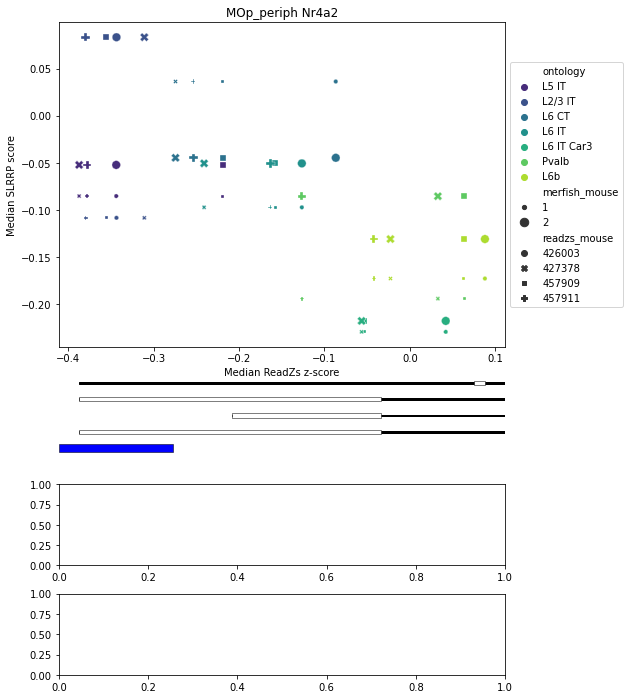

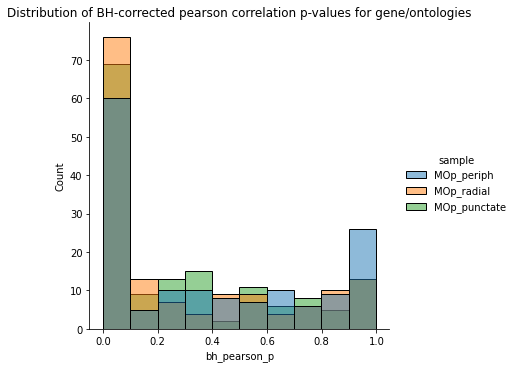

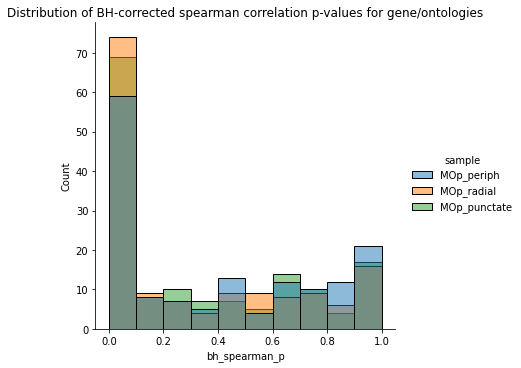

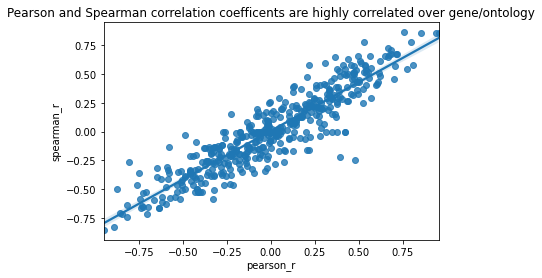

In [109]:
sns.displot(
    x = 'bh_pearson_p',
    hue = 'sample',
    data = corr_df,
)
plt.title('Distribution of BH-corrected pearson correlation p-values for gene/ontologies')
plt.show()
plt.close()

sns.displot(
    x = 'bh_spearman_p',
    hue = 'sample',
    data = corr_df,
)
plt.title('Distribution of BH-corrected spearman correlation p-values for gene/ontologies')
plt.show()
plt.close()

sns.regplot(
    x = 'pearson_r',
    y = 'spearman_r',
    data = corr_df,
)
plt.title('Pearson and Spearman correlation coefficents are highly correlated over gene/ontology')
plt.show()
plt.close()

## I'll use Spearman correlation because I'm just looking for monotonic relationship

In [110]:
corr_df['readzs_span'].nunique()

151

In [111]:
corr_df[
    corr_df['bh_spearman_p'].le(0.05) &
    corr_df['sample'].eq('MOp_periph')
].sort_values('readzs_span',ascending=False).head()

,sample,gene,num_merfish_mice,num_readzs_mice,num_celltypes,med_SRRS_cells_per_celltype,slrrp_span,readzs_span,pearson_r,pearson_p,spearman_r,spearman_p,bh_pearson_p,bh_spearman_p
137,MOp_periph,Tmem163,2,4,6,981.0,0.067586,1.939936,0.358504,4.497382e-04,0.470109,2.265815e-06,1.669929e-03,1.425575e-05
16,MOp_periph,Camk2d,2,4,13,1225.0,0.150124,1.716246,0.473942,1.080319e-11,0.469801,1.721506e-11,1.398241e-10,2.689111e-10
136,MOp_periph,Timp3,2,4,10,344.0,0.428771,1.529278,-0.876924,9.487404e-46,-0.498804,3.558630e-10,2.148897e-43,4.242261e-09
24,MOp_periph,Cdh13,2,4,12,1253.0,0.078844,1.199105,0.437177,4.286129e-08,0.504544,1.134545e-10,3.173935e-07,1.427636e-09
35,MOp_periph,Cux2,2,4,8,372.0,0.319999,1.168246,-0.183382,9.912334e-02,-0.277567,1.157951e-02,1.952299e-01,3.032093e-02


In [115]:
for sample,sample_g in corr_df.groupby('sample'):
    pdf = matplotlib.backends.backend_pdf.PdfPages('{}_readzs_slrrp_correlation.pdf'.format(sample))
    
    ordered_genes = sample_g[
        sample_g['bh_spearman_p'].le(0.05) &
        sample_g['slrrp_span'].ge(0.2)
    ].sort_values('readzs_span',ascending=False)['gene']
    
    print('{} plotting {} genes'.format(sample,len(ordered_genes)))
    
    for gene in ordered_genes:

        plot_df = gene_sample_ontology_df[gene_sample_ontology_df['gene'].eq(gene)]
        hue_order = plot_df.groupby('ontology')['median_z_scaled'].mean().sort_values().index
        
        fig,axs = plt.subplots(
            figsize=(8,12),
            nrows=4,ncols=1,
            gridspec_kw={'height_ratios': [4, 1, 1, 1]}
        )
        
        sns.scatterplot(
            x = 'median_z_scaled',
            y = 'med_score',
            hue = 'ontology',
            size = 'merfish_mouse',
            style = 'readzs_mouse',
            hue_order = hue_order,
            palette = 'viridis',
            ax = axs[0],
            data = plot_df,
        )
        axs[0].set_title('{} {}'.format(sample,gene))
        axs[0].set_xlabel('Median ReadZs z-score')
        axs[0].set_ylabel('Median SLRRP score')
        axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        count_df = plot_read_buildup_3UTR(
            gene,merf_gtf,mouse_onts,axs=axs[1:],
            onts = hue_order, ws=100,count_threshold=50,scale_bar_size=500,
        )
        #plt.show()
        pdf.savefig(bbox_inches='tight')
        plt.close()
        
    pdf.close()
    break #NOTE

MOp_periph plotting 19 genes


In [89]:
count_df.shape

(1702, 5)

In [90]:
count_df.groupby('ont')['count'].apply(lambda cs: np.cumsum(cs))

18     414
18     629
18     635
18     730
18       2
      ... 
33    5015
33     248
33     350
33     408
33     480
Name: count, Length: 1702, dtype: int64

MOp_periph plotting 1 genes


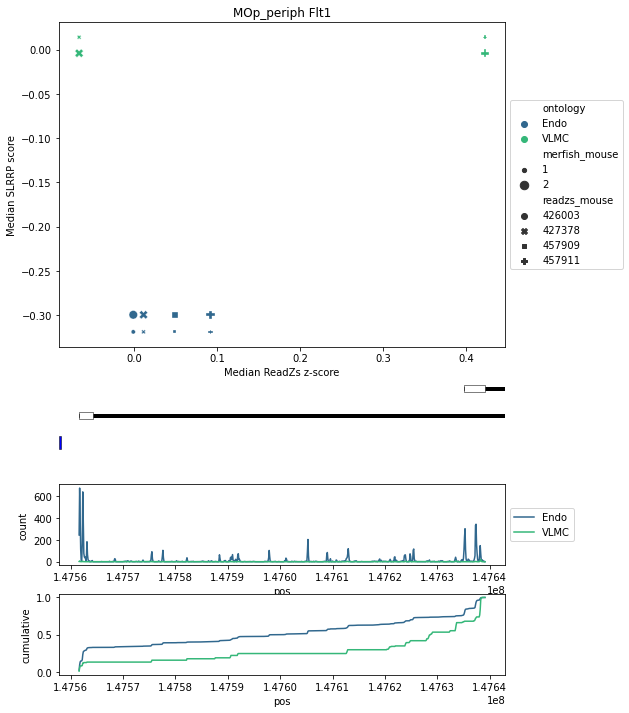

In [114]:
#All about Flt1

for sample,sample_g in corr_df.groupby('sample'):
    
    ordered_genes = sample_g[
        sample_g['gene'].eq('Flt1')
    ]['gene']
    
    print('{} plotting {} genes'.format(sample,len(ordered_genes)))
    
    for gene in ordered_genes:

        plot_df = gene_sample_ontology_df[gene_sample_ontology_df['gene'].eq(gene)]
        hue_order = plot_df.groupby('ontology')['median_z_scaled'].mean().sort_values().index
        
        fig,axs = plt.subplots(
            figsize=(8,12),
            nrows=4,ncols=1,
            gridspec_kw={'height_ratios': [4, 1, 1, 1]}
        )
        
        sns.scatterplot(
            x = 'median_z_scaled',
            y = 'med_score',
            hue = 'ontology',
            size = 'merfish_mouse',
            style = 'readzs_mouse',
            hue_order = hue_order,
            palette = 'viridis',
            ax = axs[0],
            data = plot_df,
        )
        axs[0].set_title('{} {}'.format(sample,gene))
        axs[0].set_xlabel('Median ReadZs z-score')
        axs[0].set_ylabel('Median SLRRP score')
        axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        count_df = plot_read_buildup_3UTR(
            gene,merf_gtf,mouse_onts,axs=axs[1:],
            onts = hue_order, ws=100,count_threshold=50,scale_bar_size=500,
        )
        plt.show()
        plt.close()
        
    break